In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

from numba import jit 
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import cupy as cp
import time
import matplotlib.pyplot as plt

### cupy implementation
CuPy is an open-source matrix library accelerated with NVIDIA CUDA. https://cupy.chainer.org/

In this notebook, we show how simple it is to drop-in replace numpy functions with cupy and deliver 100x speedup.

In [3]:
def cupy_hist_int(x,n):
    bins = cp.arange(n+1)-0.5
    hist,_ = cp.histogram(x,bins=bins)
    return hist

def cupy_confusion_matrix(true,pred,n):
    cf = true*n+pred
    cf = cupy_hist_int(cf,n*n)
    return cf.reshape([n,n])

def cupy_quadKappa(act,pred,n=4,hist_range=(0,3)):
    act = cp.asarray(act,dtype=cp.int32)
    pred = cp.asarray(pred,dtype=cp.int32)
    O = cupy_confusion_matrix(act,pred,n)
    O = cp.divide(O,cp.sum(O))
    
    W = cp.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = cupy_hist_int(act,n)
    prd_hist = cupy_hist_int(pred,n)
    
    E = cp.outer(act_hist,prd_hist)
    E = cp.divide(E,cp.sum(E))
    
    num = cp.sum(cp.multiply(W,O))
    den = cp.sum(cp.multiply(W,E))
        
    return 1-np.divide(num,den)

### @afajohn Method¶
https://www.kaggle.com/afajohn/quadratic-weighted-kappa-with-numpy-flavor

In [4]:
def quadKappa(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)

### @cpmpml
https://www.kaggle.com/cpmpml/ultra-fast-qwk-calc-method

In [5]:
@jit
def qwk3(a1, a2, max_rat=3):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=np.int32)
    a2 = np.asarray(a2, dtype=np.int32)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [6]:
size = 1000000
a = np.random.randint(0, 4, size)
p = np.random.randint(0, 4, size)
a.size, p.size

(1000000, 1000000)

In [7]:
%%time
quadKappa(a,p)

CPU times: user 619 ms, sys: 16.3 ms, total: 635 ms
Wall time: 636 ms


-0.0018242445183236367

### numba relies on just in time compiler so the running time for the first execution will be slower.

In [8]:
%%time
qwk3(a,p)

CPU times: user 367 ms, sys: 3.8 ms, total: 371 ms
Wall time: 374 ms


-0.0018242445183234146

In [9]:
%%time
qwk3(a,p)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 9.53 ms


-0.0005037798242659708

### cupy uses on-the-fly kernel synthesis so the running time for the first execution will also be slower.

In [10]:
%%time
cupy_quadKappa(a,p)

CPU times: user 4.72 s, sys: 232 ms, total: 4.95 s
Wall time: 5.21 s


array(-0.00050378)

In [11]:
%%time
cupy_quadKappa(a,p)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 8.11 ms


array(-0.00050378)

In [9]:
cupy_time = []
numpy_time = []
numba_time = []
for i in range(5,9):
    size = 10**i
    a = np.random.randint(0, 4, size)
    p = np.random.randint(0, 4, size)
    
    start = time.time()
    quadKappa(a,p)
    numpy_time.append(time.time()-start)
    
    start = time.time()
    cupy_quadKappa(a,p)
    cupy_time.append(time.time()-start)
    
    start = time.time()
    qwk3(a,p)
    numba_time.append(time.time()-start)

Text(0.5, 1.0, 'qwk: cupy vs numpy vs numba')

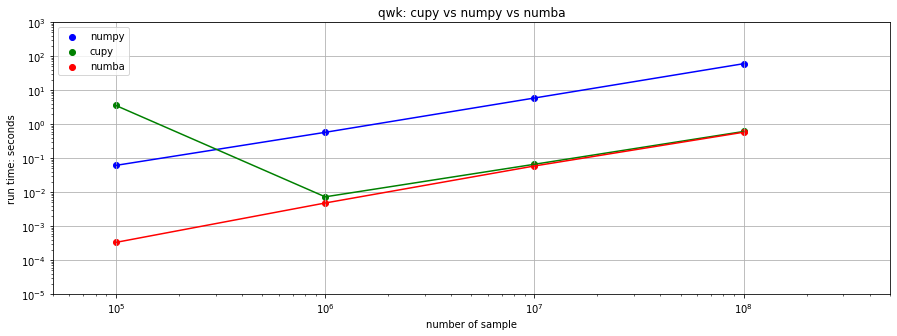

In [10]:
plt.figure(figsize=(15,5))
colors = ['b','g','r']
xs = [10**i for i in range(5,9)]
plt.yscale('log')
plt.xlim(5*10**4,5*10**8)
plt.ylim(10**(-5),10**3)
plt.xscale('log')
plt.xlabel('number of sample')
plt.ylabel('run time: seconds')
plt.grid()

plt.scatter(xs,numpy_time,c='b',label='numpy')  
plt.scatter(xs,cupy_time,c='g',label='cupy') 
plt.scatter(xs,numba_time,c='r',label='numba') 

plt.plot(xs,numpy_time,c='b')  
plt.plot(xs,cupy_time,c='g') 
plt.plot(xs,numba_time,c='r') 
plt.legend(loc='upper left')
plt.title('qwk: cupy vs numpy vs numba')

### It is amazing that numba is slightly faster than cupy despite it's on cpu. Both are about 100x faster than numpy. Cupy is still convenient without much code change if your baseline code is in numpy.